# Comparing Dispersed Images for Flare and Active Region Cases

In [48]:
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import wcs_to_celestial_frame
from astropy.visualization import ImageNormalize, LogStretch, AsymmetricPercentileInterval, quantity_support
import sunpy.map
from sunpy.map import extract_along_coord

from overlappy.io import read_overlappogram
from overlappy.util import color_lat_lon_axes
from mocksipipeline.util import stack_components


In [7]:
root_dir = pathlib.Path('data/flare-ar-comparisons')
ar_files = sorted(list(root_dir.glob('overlappogram_ar_*.fits')))
flare_files = sorted(list(root_dir.glob('overlappogram_flare_*.fits')))

In [9]:
ar_components = [read_overlappogram(f) for f in ar_files]
flare_components = [read_overlappogram(f) for f in flare_files]

In [10]:
ar_overlappogram = stack_components(ar_components, wcs_index=2)
flare_overlappogram = stack_components(flare_components, wcs_index=2)

From here out, I'm going to use the following colormap conventions:

- 'electrons': 'inferno'
- 'photons': 'viridis'

In [23]:
def get_norm_from_percentile(data, lower_percentile=1, upper_percentile=99, unit=None, stretch=LogStretch()):
    interval = AsymmetricPercentileInterval(lower_percentile, upper_percentile)
    if unit is None:
        unit = data.unit
    vmin,vmax = interval.get_limits(data.to_value(unit))
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=stretch)
    return norm

In [42]:
ar_slice = SkyCoord(Tx=75*u.arcsec, Ty=[-5600,5600]*u.arcsec, frame=wcs_to_celestial_frame(ar_overlappogram.wcs))

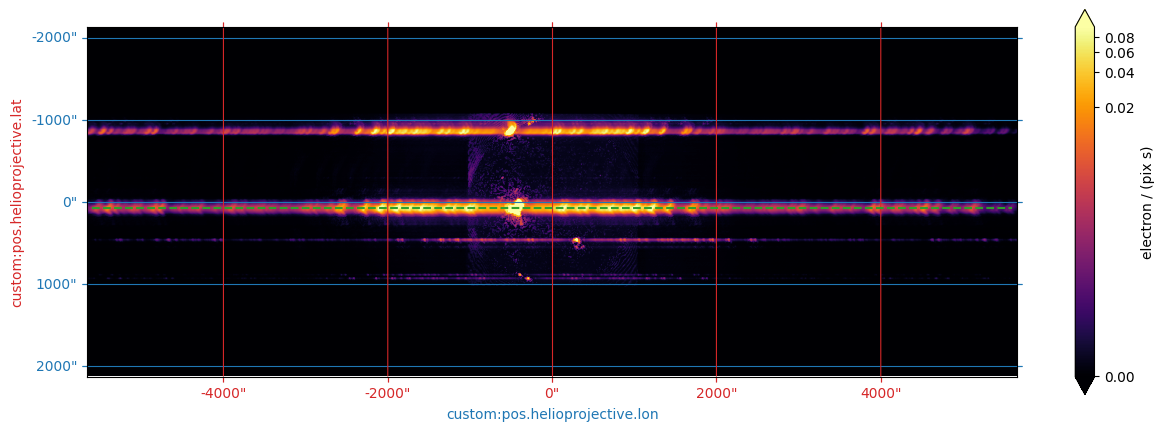

In [89]:
data_unit = u.Unit('electron / (pix s)')

fig = plt.figure(figsize=(15,5))
cropped_cube = ar_overlappogram[0,:751,:]

ax = fig.add_subplot(111, projection=cropped_cube.wcs)
cropped_cube.plot(
    axes=ax,
    norm=get_norm_from_percentile(cropped_cube.data*cropped_cube.unit, upper_percentile=99.9, unit=data_unit),
    data_unit=data_unit,
    cmap='inferno',
)
color_lat_lon_axes(ax)
ax.plot_coord(ar_slice, color='C2', ls='--')
cb = fig.colorbar(ax.get_images()[0], extend='both')
cb.set_label(data_unit)

In [44]:
flare_slice = SkyCoord(Tx=500*u.arcsec, Ty=[-5600,5600]*u.arcsec, frame=wcs_to_celestial_frame(flare_overlappogram.wcs))

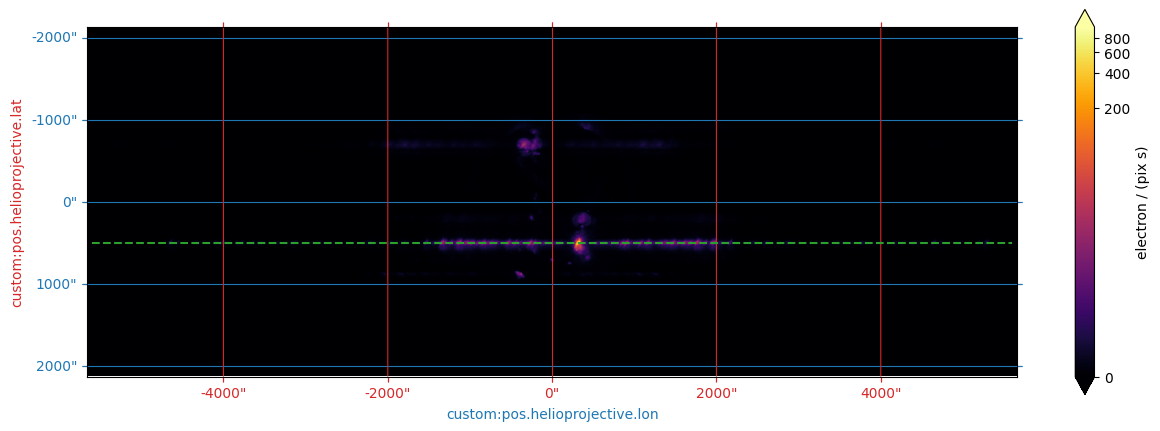

In [91]:
data_unit = u.Unit('electron / (pix s)')

fig = plt.figure(figsize=(15,5))
cropped_cube = flare_overlappogram[0,:751,:]

ax = fig.add_subplot(111, projection=cropped_cube.wcs)
cropped_cube.plot(
    axes=ax,
    norm=ImageNormalize(stretch=LogStretch()),#get_norm_from_percentile(cropped_cube.data*cropped_cube.unit, upper_percentile=99.9, unit=data_unit),
    data_unit=data_unit,
    cmap='inferno',
)
color_lat_lon_axes(ax)
ax.plot_coord(flare_slice, color='C2', ls='--')
cb = fig.colorbar(ax.get_images()[0], extend='both')
cb.set_label(data_unit)

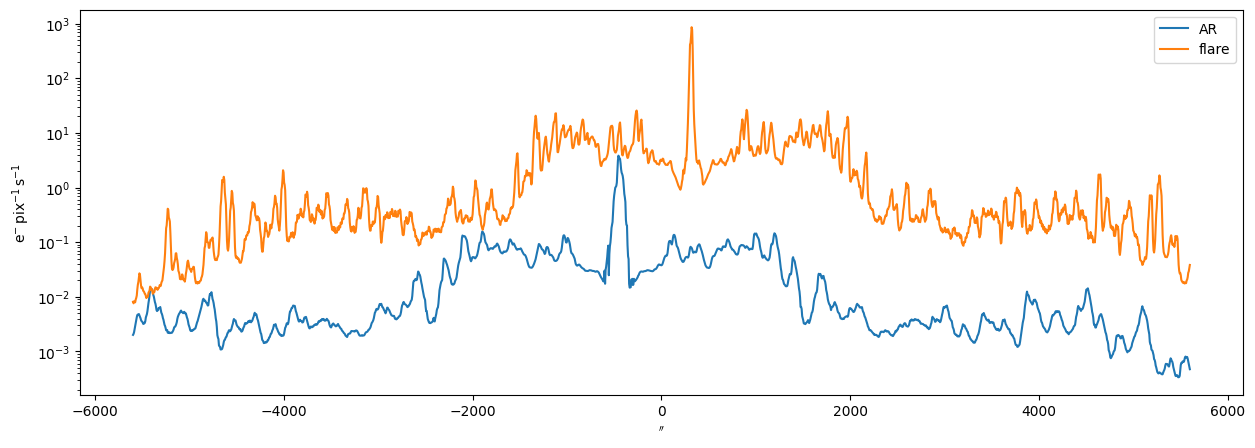

In [54]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
with quantity_support():
    intensities,coord = extract_along_coord(ar_overlappogram[0], ar_slice)
    ax.plot(coord.Ty, intensities, label='AR')
    intensities,coord = extract_along_coord(flare_overlappogram[0], flare_slice)
    ax.plot(coord.Ty, intensities, label='flare')
ax.set_yscale('log')
ax.legend()